# Association Rules Mining Using Python Generators to Handle Large Datasets

### Python Generators

Python generator are special type of functions that returns an iterable sequence of items.  However, unlike regular functions which return all the values at once (eg: returning all the elements of a list), a generator <i>yields</i> one value at a time.  To get the next value in the set, we must ask for it - either by explicitly calling the generator's built-in "next" method, or implicitly via a for loop.  This is a great property of generators because it means that we don't have to store all of the values in memory at once.  We can load and process one value at a time, discard when finished and move on to process the next value.  This feature makes generators perfect for creating item pairs and counting their frequency of co-occurence.  Here's a concrete example of what we're trying to accomplish:  

1. Get all possible item pairs for a given order 
       eg:  order 1:  apple, egg, milk   -->  item pairs: {apple, egg}, {apple, milk}, {egg, milk}
            order 2:  egg, milk          -->  item pairs: {egg, milk}
            
2. Count the number of times each item pair appears
       eg: {apple, egg}: 1
           {apple, milk}: 1
           {egg, milk}: 2

Here's the generator that implements the above tasks:

In [1]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

# Sample data
orders = np.array([[1,'apple'], [1,'egg'], [1,'milk'], [2,'egg'], [2,'milk']], dtype=object)

# Generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    
    # For each order, generate a list of items in that order
    for order_id, order_object in groupby(orders, lambda x: x[0]):
        item_list = [item[1] for item in order_object]      
    
        # For each item list, generate item pairs, one at a time
        for item_pair in combinations(item_list, 2):
            yield item_pair                                      


# Counter iterates through the item pairs returned by our generator and keeps a tally of their occurrence
Counter(get_item_pairs(orders))

Counter({('apple', 'egg'): 1, ('apple', 'milk'): 1, ('egg', 'milk'): 2})

<i>get_item_pairs()</i> generates a list of items for each order and produces item pairs for that order, one pair at a time.  The first item pair is passed to Counter which keeps track of the number of times an item pair occurs.  The next item pair is taken, and again, passed to Counter.  This process continues until there are no more item pairs left.  With this approach, we end up not using much memory as item pairs are discarded after the count is updated.

### Apriori Algorithm 
Apriori is an algorithm used to identify frequent item sets (in our case, item pairs).  It does so using a "bottom up" approach, first identifying individual items that satisfy a minimum occurence threshold. It then extends the item set, adding one item at a time and checking if the resulting item set still satisfies the specified threshold.  The algorithm stops when there are no more items to add that meet the minimum occurrence requirement.  Here's an example of apriori in action, assuming a minimum occurence threshold of 3:


    order 1: apple, egg, milk  
    order 2: carrot, milk  
    order 3: apple, egg, carrot
    order 4: apple, egg
    order 5: apple, carrot

    
    Iteration 1:  Count the number of times each item occurs   
    item set      occurrence count    
    {apple}              4   
    {egg}                3   
    {milk}               2   
    {carrot}             3   

    {milk} and {carrot} are eliminated because they do not meet the minimum occurrence threshold.


    Iteration 2: Build item sets of size 2 using the remaining items from Iteration 1 
                 (ie: apple, egg)  
    item set           occurence count  
    {apple, egg}             3  

    Only {apple, egg} remains and the algorithm stops since there are no more items to add.
   
   
If we had more orders and items, we can continue to iterate, building item sets consisting of more than 2 elements.  For the problem we are trying to solve (ie: finding relationships between pairs of items), it suffices to implement apriori to get to item sets of size 2.

### Association Rules Mining
Once the item sets have been generated using apriori, we can start mining association rules.  Given that we are only looking at item sets of size 2, the association rules we will generate will be of the form {A} -> {B}.  One common application of these rules is in the domain of recommender systems, where customers who purchased item A are recommended item B.

Here are 3 key metrics to consider when evaluating association rules:

1. <b>support</b>  
    This is the percentage of orders that contains the item set. In the example above, there are 5 orders in total 
    and {apple,egg} occurs in 3 of them, so: 
       
                    support{apple,egg} = 3/5 or 60%
        
    The minimum support threshold required by apriori can be set based on knowledge of your domain.  In this 
    grocery dataset for example, since there could be thousands of distinct items and an order can contain 
    only a small fraction of these items, setting the support threshold to 0.01% may be reasonable.<br><br><br>
    
2. <b>confidence</b>  
    Given two items, A and B, confidence measures the percentage of times that item B is purchased, given that 
    item A was purchased. This is expressed as:
       
                    confidence{A->B} = support{A,B} / support{A}   
                    
    Confidence values range from 0 to 1, where 0 indicates that B is never purchased when A is purchased, and 1 
    indicates that B is always purchased whenever A is purchased.  Note that the confidence measure is directional.     This means that we can also compute the percentage of times that item A is purchased, given that item B was 
    purchased:
       
                    confidence{B->A} = support{A,B} / support{B}    
                    
    In our example, the percentage of times that egg is purchased, given that apple was purchased is:  
       
                    confidence{apple->egg} = support{apple,egg} / support{apple}
                                           = (3/5) / (4/5)
                                           = 0.75 or 75%

    A confidence value of 0.75 implies that out of all orders that contain apple, 75% of them also contain egg.  Now, 
    we look at the confidence measure in the opposite direction (ie: egg->apple): 
       
                    confidence{egg->apple} = support{apple,egg} / support{egg}
                                           = (3/5) / (3/5)
                                           = 1 or 100%  
                                           
    Here we see that all of the orders that contain egg also contain apple.  But, does this mean that there is a 
    relationship between these two items, or are they occurring together in the same orders simply by chance?  To 
    answer this question, we look at another measure which takes into account the popularity of <i>both</i> items.<br><br><br>  
    
3. <b>lift</b>  
    Given two items, A and B, lift indicates whether there is a relationship between A and B, or whether the two items 
    are occuring together in the same orders simply by chance (ie: at random).  Unlike the confidence metric whose 
    value may vary depending on direction (eg: confidence{A->B} may be different from confidence{B->A}), 
    lift has no direction. This means that the lift{A,B} is always equal to the lift{B,A}: 
       
                    lift{A,B} = lift{B,A} = support{A,B} / (support{A} * support{B})   
    
    In our example, we compute lift as follows:
    
         lift{apple,egg} = lift{egg,apple} = support{apple,egg} / (support{apple} * support{egg})
                         = (3/5) / (4/5 * 3/5) 
                         = 1.25    
               
    One way to understand lift is to think of the denominator as the likelihood that A and B will appear in the same 
    order if there was <i>no</i> relationship between them. In the example above, if apple occurred in 80% of the
    orders and egg occurred in 60% of the orders, then if there was no relationship between them, we would 
    <i>expect</i> both of them to show up together in the same order 48% of the time (ie: 80% * 60%).  The numerator, 
    on the other hand, represents how often apple and egg <i>actually</i> appear together in the same order.  In 
    this example, that is 60% of the time.  Taking the numerator and dividing it by the denominator, we get to how 
    many more times apple and egg actually appear in the same order, compared to if there was no relationship between     them (ie: that they are occurring together simply at random).  
    
    In summary, lift can take on the following values:
    
        * lift = 1 implies no relationship between A and B. 
          (ie: A and B occur together only by chance)
      
        * lift > 1 implies that there is a positive relationship between A and B.
          (ie:  A and B occur together more often than random)
    
        * lift < 1 implies that there is a negative relationship between A and B.
          (ie:  A and B occur together less often than random)
        
    In our example, apple and egg occur together 1.25 times <i>more</i> than random, so we conclude that there exists 
    a positive relationship between them.
   
Armed with knowledge of apriori and association rules mining, let's dive into the data and code to see what relationships we unravel!

### Input Dataset
Instacart, an online grocer, has graciously made some of their datasets accessible to the public.  The order and product datasets that we will be using can be downloaded from the link below, along with the data dictionary:

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on September 1, 2017.<br><br>

In [2]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display

In [3]:
# Function that returns the size of an object in MB
def size(obj):
    return "{0:.2f} MB".format(sys.getsizeof(obj) / (1000 * 1000))

### Part 1:  Data Preparation

#### A. Load order  data

In [4]:
orders = pd.read_csv('instacart_transaction.csv')
print('orders -- dimensions: {0};   size: {1}'.format(orders.shape, size(orders)))
display(orders.head())

orders -- dimensions: (32434489, 4);   size: 1037.90 MB


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [15]:
orders.describe(include = 'add_to_cart_order')

count    3.243449e+07
mean     2.557634e+04
std      1.409669e+04
min      1.000000e+00
25%      1.353000e+04
50%      2.525600e+04
75%      3.793500e+04
max      4.968800e+04
Name: item_id, dtype: float64

#### B. Convert order data into format expected by the association rules function

In [5]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders.set_index('order_id')['product_id'].rename('item_id')
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

#### C. Display summary statistics for order data

In [6]:
print('dimensions: {0};   size: {1};   unique_orders: {2};   unique_items: {3}'
      .format(orders.shape, size(orders), len(orders.index.unique()), len(orders.value_counts())))

dimensions: (32434489,);   size: 518.95 MB;   unique_orders: 3214874;   unique_items: 49677


### Part 2: Association Rules Function

#### A. Helper functions to the main association rules function

In [7]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().to_numpy()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]               

#### B. Association rules function

In [8]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item)


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item)


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders)

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    #print(item_pairs)
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

### Part 3:  Association Rules Mining

In [9]:
%%time
rules = association_rules(orders, 0.01)
print(rules)
print("-*-*-*-*-*-*")
print(len(rules))

Starting order_item:               32434489
Items with support >= 0.01:             102
Remaining order_item:               7548766
Remaining orders with 2+ items:     1664863
Remaining order_item:               6859117
Item pairs:                           10290
Item pairs with support >= 0.01:         28

    item_A  item_B  freqAB  supportAB   freqA  supportA   freqB  supportB  \
14   24852   28204   23876   0.014341  401800  0.241341   82313  0.049441   
13   24852   45066   20196   0.012131  401800  0.241341   74704  0.044871   
26   24852    4920   18493   0.011108  401800  0.241341   74794  0.044925   
0    13176   27966   25620   0.015389  327763  0.196871  127862  0.076800   
5    24852   49683   22213   0.013342  401800  0.241341   91679  0.055067   
15   24852   16797   29182   0.017528  401800  0.241341  122223  0.073413   
20   27966   21137   18374   0.011036  127862  0.076800  244163  0.146657   
1    13176   47209   37628   0.022601  327763  0.196871  199786  0.120001  

Starting order_item:               32434489
Items with support >= 0.01:             102
Remaining order_item:               7548766
Remaining orders with 2+ items:     1664863
Remaining order_item:               6859117
Item pairs:                           10290
Item pairs with support >= 0.01:         28

    item_A  item_B  freqAB  supportAB   freqA  supportA   freqB  supportB  \
14   24852   28204   23876   0.014341  401800  0.241341   82313  0.049441   
13   24852   45066   20196   0.012131  401800  0.241341   74704  0.044871   
26   24852    4920   18493   0.011108  401800  0.241341   74794  0.044925   
0    13176   27966   25620   0.015389  327763  0.196871  127862  0.076800   
5    24852   49683   22213   0.013342  401800  0.241341   91679  0.055067   
15   24852   16797   29182   0.017528  401800  0.241341  122223  0.073413   
20   27966   21137   18374   0.011036  127862  0.076800  244163  0.146657   
1    13176   47209   37628   0.022601  327763  0.196871  199786  0.120001  

Items with support >= 0.08:               3
Remaining order_item:               1116698
Remaining orders with 2+ items:      118546
Remaining order_item:                237299
Item pairs:                               6
Item pairs with support >= 0.08:          4

   item_A  item_B  freqAB  supportAB   freqA  supportA   freqB  supportB  \
0   24852   21137   38564   0.325308   57125  0.481880  117577  0.991826   
2   13176   21137   40029   0.337666   62597  0.528040  117577  0.991826   
3   21137   13176   21599   0.182199  117577  0.991826   62597  0.528040   
1   21137   24852   17592   0.148398  117577  0.991826   57125  0.481880   

   confidenceAtoB  confidenceBtoA      lift  
0        0.675081        0.327989  0.680645  
2        0.639472        0.340449  0.644742  
3        0.183701        0.345048  0.347892  
1        0.149621        0.307956  0.310494  
---------
---------
Starting order_item:               32434489
Items with support >= 0.1:               2
Remaining order_i

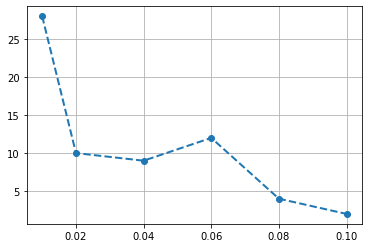

CPU times: total: 46.2 s
Wall time: 46.6 s


In [10]:
%%time
import matplotlib.pyplot as plt
min_sup = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
num = []
for i in min_sup:
    rules = association_rules(orders, i)
    print(rules)
    num1 = len(rules)
    num = np.append(num,num1)
    #print(num)
    print("---------")
    print("---------")
    #num=append.(num1)
print(min_sup)
print(num)
#plot the number of items and the corresponding support threshold
plt.plot(min_sup, num, linestyle = "dashed", linewidth =2, marker = 'o', markersize=6)
plt.grid()
plt.show()

In [11]:
# Replace item ID with item name and display association rules
item_name   = pd.read_csv('products.csv')
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Banana,Bag of Organic Bananas,654,0.556122,1176,1.0,1176,1.0,0.556122,0.556122,0.556122
1,Bag of Organic Bananas,Banana,522,0.443878,1176,1.0,1176,1.0,0.443878,0.443878,0.443878


### Part 4:  Conclusion

From the output above, we see that the top associations are not surprising, with one flavor of an item being purchased with another flavor from the same item family (eg: Strawberry Chia Cottage Cheese with Blueberry Acai Cottage Cheese, Chicken Cat Food with Turkey Cat Food, etc).  As mentioned, one common application of association rules mining is in the domain of recommender systems.  Once item pairs have been identified as having positive relationship, recommendations can be made to customers in order to increase sales.  And hopefully, along the way, also introduce customers to items they never would have tried before or even imagined existed!.This notebook is adaption from the following kaggle notebook https://www.kaggle.com/datatheque/association-rules-mining-market-basket-analysis. 